# Audio Feature extraction

In [1]:
import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T

print(torch.__version__)
print(torchaudio.__version__)

import librosa
import matplotlib.pyplot as plt

2.1.0
2.1.0


## Overview of audio features

![](https://download.pytorch.org/torchaudio/tutorial-assets/torchaudio_feature_extractions.png)

## Preparation

In [2]:
from IPython.display import Audio
from matplotlib.patches import Rectangle
from torchaudio.utils import download_asset

torch.random.manual_seed(0)

SAMPLE_SPEECH = download_asset("tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav")


def plot_waveform(waveform, sr, title="Waveform", ax=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sr

    if ax is None:
        _, ax = plt.subplots(num_channels, 1)
    ax.plot(time_axis, waveform[0], linewidth=1)
    ax.grid(True)
    ax.set_xlim([0, time_axis[-1]])
    ax.set_title(title)


def plot_spectrogram(specgram, title=None, ylabel="freq_bin", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto", interpolation="nearest")


def plot_fbank(fbank, title=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Filter bank")
    axs.imshow(fbank, aspect="auto")
    axs.set_ylabel("frequency bin")
    axs.set_xlabel("mel bin")

## Spectrogram

In [3]:
# Load audio
SPEECH_WAVEFORM, SAMPLE_RATE = torchaudio.load(SAMPLE_SPEECH)

# Define transform
spectrogram = T.Spectrogram(n_fft=512)

# Perform transform
spec = spectrogram(SPEECH_WAVEFORM)

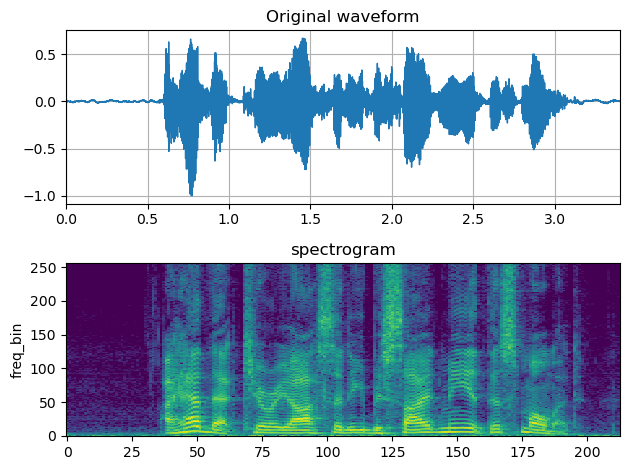

In [4]:
fig, axs = plt.subplots(2, 1)
plot_waveform(SPEECH_WAVEFORM, SAMPLE_RATE, title="Original waveform", ax=axs[0])
plot_spectrogram(spec[0], title="spectrogram", ax=axs[1])
fig.tight_layout()

In [5]:
Audio(SPEECH_WAVEFORM.numpy(), rate=SAMPLE_RATE)

### The effect of `n_fft` parameter

Cốt lõi của tính toán biểu đồ phổ là biến đổi Fourier

Giá trị `n_fft` xác định độ phân giải của trục tần số. 

Tuy nhiên, với giá trị `n_fft` càng cao, năng lượng sẽ được phân bổ vào nhiều thùng hơn 

nên khi bạn hình dung, nó có thể trông mờ hơn, thậm chí tưởng rằng chúng có độ phân giải cao hơn.

> Note:
> `hop_length` xác định độ phân giải trục thời gian. 


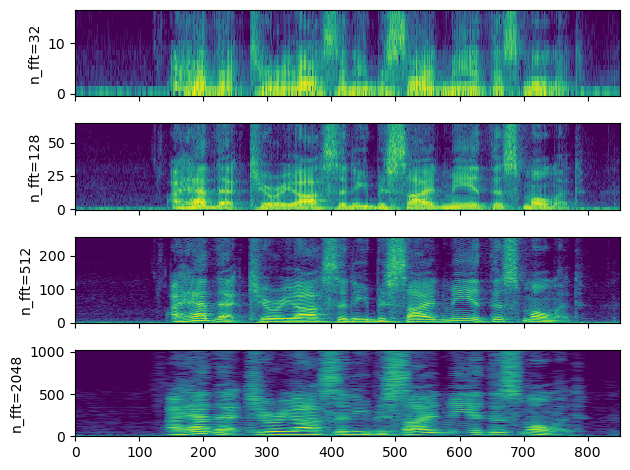

In [6]:
n_ffts = [32, 128, 512, 2048]
hop_length = 64

specs = []
for n_fft in n_ffts:
    spectrogram = T.Spectrogram(n_fft=n_fft, hop_length=hop_length)
    spec = spectrogram(SPEECH_WAVEFORM)
    specs.append(spec)
fig, axs = plt.subplots(len(specs), 1, sharex=True)
for i, (spec, n_fft) in enumerate(zip(specs, n_ffts)):
    plot_spectrogram(spec[0], ylabel=f"n_fft={n_fft}", ax=axs[i])
    axs[i].set_xlabel(None)
fig.tight_layout()

Khi so sánh các tín hiệu, bạn nên sử dụng cùng một tốc độ lấy mẫu, tuy nhiên nếu bạn phải sử dụng tốc độ lấy mẫu khác thì phải cẩn thận khi diễn giải ý nghĩa của `n_fft`. Hãy nhớ lại việc      xác định độ phân giải của trục tần số cho một tốc độ lấy mẫu nhất định. Nói cách khác, những gì mỗi thùng trên trục tần số thể hiện phụ thuộc vào tốc độ lấy mẫu.

Như chúng ta đã thấy ở trên, việc thay đổi giá trị `n_fft` không làm thay đổi phạm vi phủ sóng của dải tần đối với cùng một tín hiệu đầu vào.

In [7]:
# Downsample to half of the original sample rate
speech2 = torchaudio.functional.resample(SPEECH_WAVEFORM, SAMPLE_RATE, SAMPLE_RATE // 2)
# Upsample to the original sample rate
speech3 = torchaudio.functional.resample(speech2, SAMPLE_RATE // 2, SAMPLE_RATE)

In [8]:
# Apply the same spectrogram
spectrogram = T.Spectrogram(n_fft=512)

spec0 = spectrogram(SPEECH_WAVEFORM)
spec2 = spectrogram(speech2)
spec3 = spectrogram(speech3)

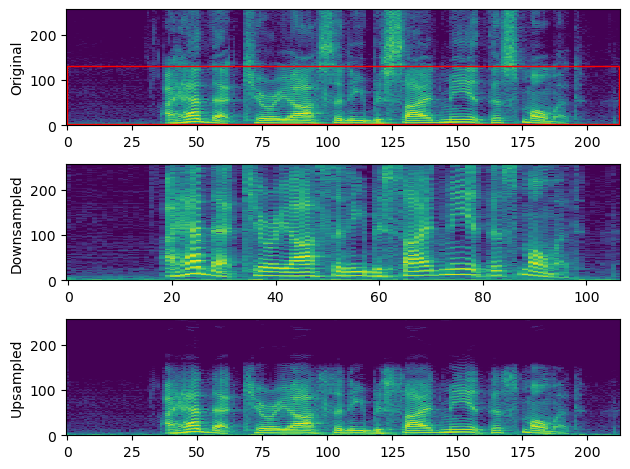

In [9]:
# Visualize it
fig, axs = plt.subplots(3, 1)
plot_spectrogram(spec0[0], ylabel="Original", ax=axs[0])
axs[0].add_patch(Rectangle((0, 3), 212, 128, edgecolor="r", facecolor="none"))
plot_spectrogram(spec2[0], ylabel="Downsampled", ax=axs[1])
plot_spectrogram(spec3[0], ylabel="Upsampled", ax=axs[2])
fig.tight_layout()

## GriffinLim

Để khôi phục dạng sóng từ biểu đồ phổ, bạn có thể sử dụng torchaudio.transforms.GriffinLim.

Phải sử dụng cùng một bộ tham số được sử dụng cho biểu đồ phổ.

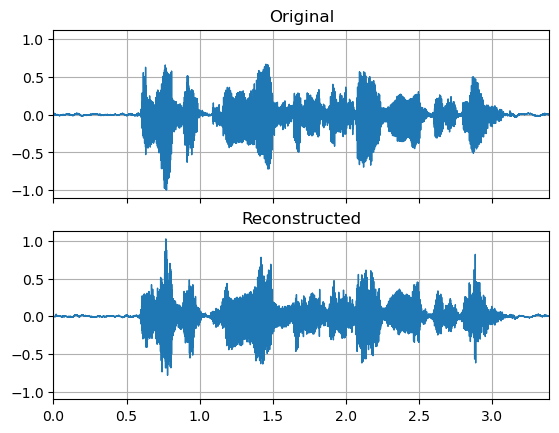

In [10]:
# Define transforms
n_fft = 1024
spectrogram = T.Spectrogram(n_fft=n_fft)
griffin_lim = T.GriffinLim(n_fft=n_fft)

# Apply the transforms
spec = spectrogram(SPEECH_WAVEFORM)
reconstructed_waveform = griffin_lim(spec)
_, axes = plt.subplots(2, 1, sharex=True, sharey=True)
plot_waveform(SPEECH_WAVEFORM, SAMPLE_RATE, title="Original", ax=axes[0])
plot_waveform(reconstructed_waveform, SAMPLE_RATE, title="Reconstructed", ax=axes[1])
Audio(reconstructed_waveform, rate=SAMPLE_RATE)

## Mel Filter Bank

generates the filter bank for converting frequency bins to mel-scale bins.

In [11]:
n_fft = 256
n_mels = 64
sample_rate = 6000

mel_filters = F.melscale_fbanks(
    int(n_fft // 2 + 1),
    n_mels=n_mels,
    f_min=0.0,
    f_max=sample_rate / 2.0,
    sample_rate=sample_rate,
    norm="slaney",
)

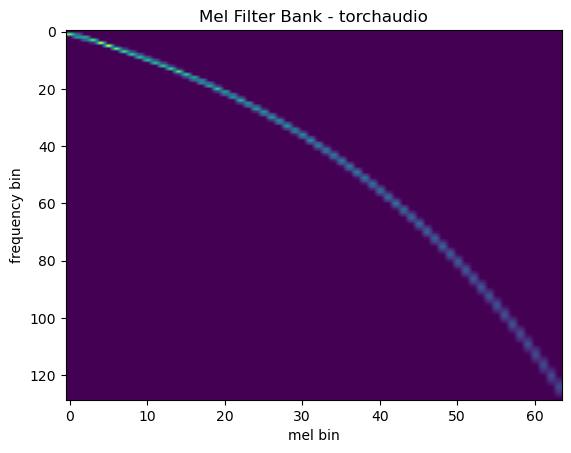

In [12]:
plot_fbank(mel_filters, "Mel Filter Bank - torchaudio")

### Comparison against librosa

In [13]:
mel_filters_librosa = librosa.filters.mel(
    sr=sample_rate,
    n_fft=n_fft,
    n_mels=n_mels,
    fmin=0.0,
    fmax=sample_rate / 2.0,
    norm="slaney",
    htk=True,
).T

Mean Square Difference:  3.934872696751886e-17


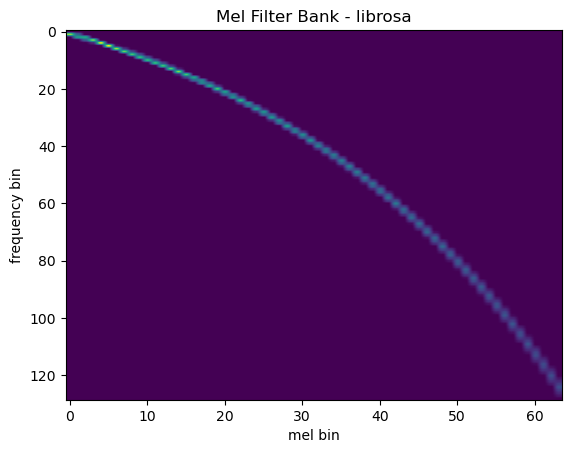

In [14]:
plot_fbank(mel_filters_librosa, "Mel Filter Bank - librosa")

mse = torch.square(mel_filters - mel_filters_librosa).mean().item()
print("Mean Square Difference: ", mse)


## MelSpectrogram

Generating a mel-scale spectrogram involves (liên quan đến) generating a spectrogram and performing mel-scale conversion. 

In [15]:
n_fft = 1024
win_length = None
hop_length = 512
n_mels = 128

mel_spectrogram = T.MelSpectrogram(
    sample_rate=sample_rate,
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
    norm="slaney",
    n_mels=n_mels,
    mel_scale="htk",
)

melspec = mel_spectrogram(SPEECH_WAVEFORM)

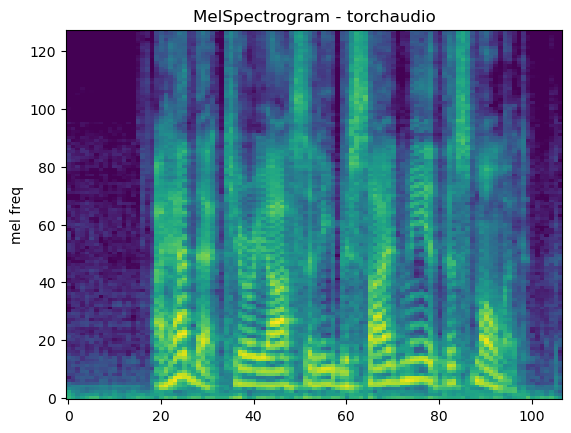

In [16]:
plot_spectrogram(melspec[0], title="MelSpectrogram - torchaudio", ylabel="mel freq")

### Comparison against librosa


In [17]:
melspec_librosa = librosa.feature.melspectrogram(
    y=SPEECH_WAVEFORM.numpy()[0],
    sr=sample_rate,
    n_fft=n_fft,
    hop_length=hop_length,
    win_length=win_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
    n_mels=n_mels,
    norm="slaney",
    htk=True,
)

Mean Square Difference:  1.2912714231205769e-09


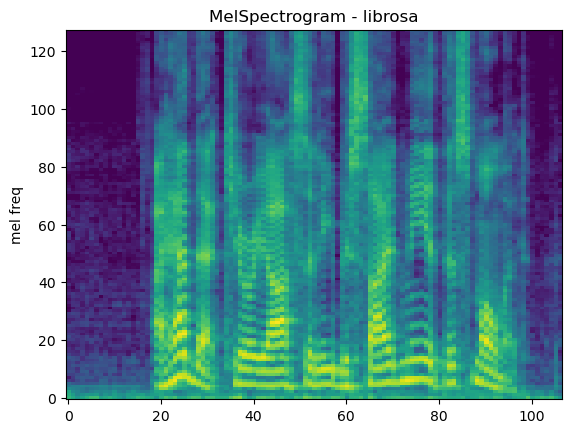

In [18]:
plot_spectrogram(melspec_librosa, title="MelSpectrogram - librosa", ylabel="mel freq")

mse = torch.square(melspec - melspec_librosa).mean().item()
print("Mean Square Difference: ", mse)

## MFCC

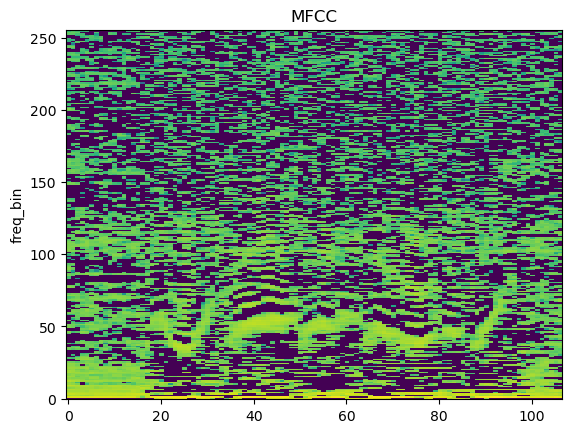

In [19]:
n_fft = 2048
win_length = None
hop_length = 512
n_mels = 256
n_mfcc = 256

mfcc_transform = T.MFCC(
    sample_rate=sample_rate,
    n_mfcc=n_mfcc,
    melkwargs={
        "n_fft": n_fft,
        "n_mels": n_mels,
        "hop_length": hop_length,
        "mel_scale": "htk",
    },
)

mfcc = mfcc_transform(SPEECH_WAVEFORM)
plot_spectrogram(mfcc[0], title="MFCC")

### Comparison against librosa

Mean Square Difference:  0.8103960156440735


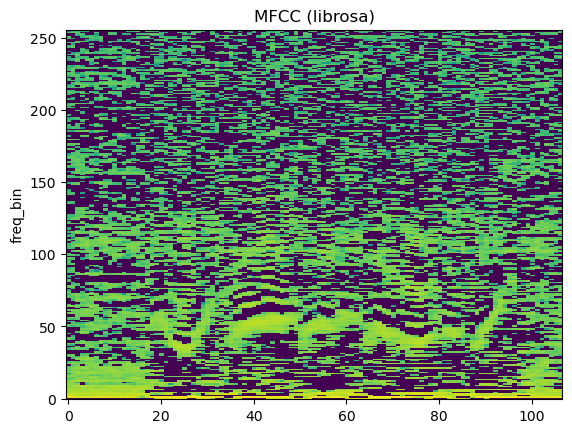

In [20]:
melspec = librosa.feature.melspectrogram(
    y=SPEECH_WAVEFORM.numpy()[0],
    sr=sample_rate,
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    n_mels=n_mels,
    htk=True,
    norm=None,
)

mfcc_librosa = librosa.feature.mfcc(
    S=librosa.core.spectrum.power_to_db(melspec),
    n_mfcc=n_mfcc,
    dct_type=2,
    norm="ortho",
)
plot_spectrogram(mfcc_librosa, title="MFCC (librosa)")

mse = torch.square(mfcc - mfcc_librosa).mean().item()
print("Mean Square Difference: ", mse)

## LFCC

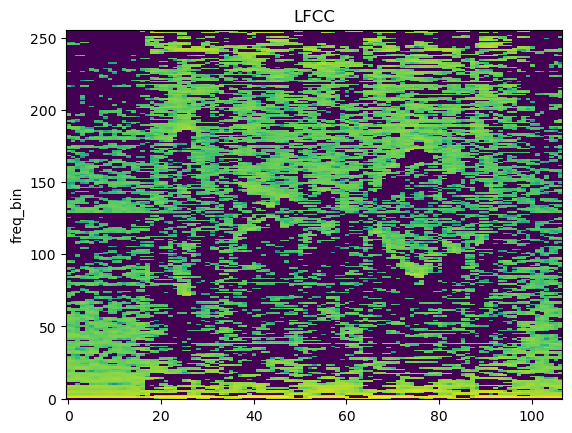

In [21]:
n_fft = 2048
win_length = None
hop_length = 512
n_lfcc = 256

lfcc_transform = T.LFCC(
    sample_rate=sample_rate,
    n_lfcc=n_lfcc,
    speckwargs={
        "n_fft": n_fft,
        "win_length": win_length,
        "hop_length": hop_length,
    },
)

lfcc = lfcc_transform(SPEECH_WAVEFORM)
plot_spectrogram(lfcc[0], title="LFCC")

## Pitch

In [22]:
pitch = F.detect_pitch_frequency(SPEECH_WAVEFORM, SAMPLE_RATE)

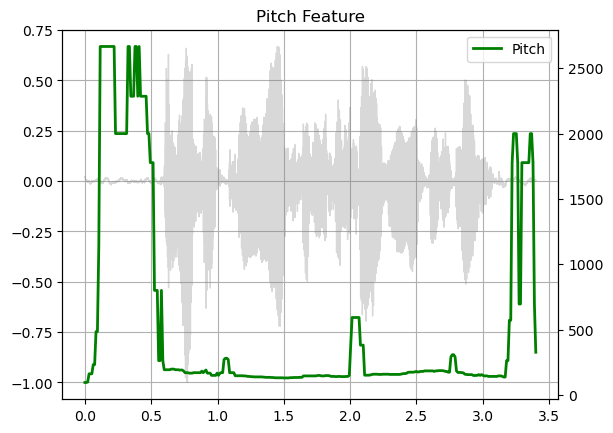

In [23]:
def plot_pitch(waveform, sr, pitch):
    figure, axis = plt.subplots(1, 1)
    axis.set_title("Pitch Feature")
    axis.grid(True)

    end_time = waveform.shape[1] / sr
    time_axis = torch.linspace(0, end_time, waveform.shape[1])
    axis.plot(time_axis, waveform[0], linewidth=1, color="gray", alpha=0.3)

    axis2 = axis.twinx()
    time_axis = torch.linspace(0, end_time, pitch.shape[1])
    axis2.plot(time_axis, pitch[0], linewidth=2, label="Pitch", color="green")

    axis2.legend(loc=0)


plot_pitch(SPEECH_WAVEFORM, SAMPLE_RATE, pitch)